# Import Libraries and Data

In [50]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, set_seed, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm
from pandas_profiling import ProfileReport



In [51]:
fileName = 'Data/pf_reviews.sqlite'
conn = sql.connect(fileName)

artists = pd.read_sql_query('SELECT * FROM artists', conn)
content = pd.read_sql_query('SELECT * FROM content', conn)
genres = pd.read_sql_query('SELECT * FROM genres', conn)
labels = pd.read_sql_query('SELECT * FROM labels', conn)
reviews = pd.read_sql_query('SELECT * FROM reviews', conn)
years = pd.read_sql_query('SELECT * FROM years', conn)

In [4]:
conn.close()

Write csv files for easier access on colab

In [33]:
artists.to_csv('Data/artists.csv')
content.to_csv('Data/content.csv')
genres.to_csv('Data/genres.csv')
labels.to_csv('Data/labels.csv')
reviews.to_csv('Data/reviews.csv')
years.to_csv('Data/years.csv')

# Data at a glance

## Artists

### Profile

In [11]:
ProfileReport(artists)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes

Some artists like Neil Young and David Bowie have more than one review associated with them

To plot: Histogram of number of reviews for a given artist

## Content

### Profile

In [12]:
ProfileReport(content)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes

This is the real interesting part of the data. 
I would like to do some sentiment analysis later.
Possibly try to infer the final review score given the review content

To plot: Histogram of length (in # of words) of review content

## Genres

### Profile

In [6]:
ProfileReport(genres)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes

Is there anything significant about the 10% of reviews with missing genres?

In [7]:
urlNoGenre = pd.merge(
    left = genres[genres['genre'].isna()], right = reviews[['reviewid', 'url']],
    how = 'left', on = 'reviewid')
print(urlNoGenre.head(5))

   reviewid genre                                                url
0     22722  None  http://pitchfork.com/reviews/albums/22722-inse...
1     22665  None  http://pitchfork.com/reviews/albums/22665-punk...
2     22690  None  http://pitchfork.com/reviews/albums/22690-hear...
3     22697  None  http://pitchfork.com/reviews/albums/22697-throat/
4     22673  None  http://pitchfork.com/reviews/albums/22673-the-...


A quick check of some of these reviews shows that no genre is a mix of reviews that no longer exist, and reviews of albums that genuinely do not fit into the other categories.
I will drop the reviews with no genre for now. Future work I would scrape the urls to find the reviews of albums that don't lead to a 404 error and actually have no genre.

I'm curious how the dynamic of genres have changed over the years.

To plot: The representation of the 6 genre categories over the years.

## Labels

### Profile

In [8]:
ProfileReport(labels)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes

To plot: Histogram of number of reviews associated with a given label.
To plot: Number of self-released albums reviewed over the years.
Maybe the rise and fall of major labels over the years.

## Reviews

### Profile

In [11]:
ProfileReport(reviews)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes

Predicting reviews for best new music would be interesting but probably quite difficult due to the class imbalance problem.

There are very few reviews published in 2017, this is due to when the data was scraped.
I will remove these reviews when doing analysis over time

There are fewer than 500 unique review authors
To plot: 
Number of unique authors over the years
Average number of reviews per author over the years
Score/Best New Music

## Years

### Profile

In [13]:
ProfileReport(years)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Interesting that an album as far back as 1959 was reviewed.
To plot:
Scatterplot of album year over published year

Final Notes: 
Many of the dataframes had duplicate rows.
Drop reviews published in 2017.

# Plots

When doing genre stuff keep only unique reviewids. 

In [42]:
#Remove duplicates

for df in [artists, content, genres, labels, reviews, years]:
    df.drop_duplicates(inplace = True)

In [46]:
ids_2017 = reviews[reviews.pub_year != 2017]['reviewid']
ids_no_genre = genres[~genres.genre.isna()]['reviewid']
review_id_list = list(set(ids_2017)&set(ids_no_genre))

In [47]:
artists = artists[artists.reviewid.isin(review_id_list)]

In [49]:
numartists = artists.groupby('artists').agg({'reviewid':count})

KeyError: 'artists'

In [48]:
artists.head()

reviewid             artist
19     22719  chance the rapper
20     22719            jeremih
21     22667    jamire williams
22     22691          the-dream
23     22702     worm ouroboros

In [ ]:
review.drop()

In [41]:
reviews.pub_year.unique()

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999])

In [36]:
ids_2017 = reviews[reviews.pub_year != 2017]['reviewid']

In [39]:
reviews[reviews.reviewid.isin(ids_2017)].pub_year.unique()

array([2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2004, 2003, 2002, 2001, 2000, 1999])

In [35]:
reviews.pub_year.unique()

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999])

In [33]:
reviews.reviewid.sort_values()

14637        1
16144        6
16990        7
14164        8
17020       10
         ...  
1        22721
5        22722
9        22724
4        22725
11       22745
Name: reviewid, Length: 18389, dtype: int64

In [31]:
artists.reviewid.sort_values()

14961        1
16523        6
17395        7
14473        8
17427       10
         ...  
1        22721
6        22722
10       22724
5        22725
12       22745
Name: reviewid, Length: 18827, dtype: int64

In [34]:
reviews.head()

reviewid                 title            artist  \
0     22703             mezzanine    massive attack   
1     22721          prelapsarian          krallice   
2     22659  all of them naturals      uranium club   
3     22661           first songs  kleenex, liliput   
4     22725             new start              taso   

                                                 url  score  best_new_music  \
0  http://pitchfork.com/reviews/albums/22703-mezz...    9.3               0   
1  http://pitchfork.com/reviews/albums/22721-prel...    7.9               0   
2  http://pitchfork.com/reviews/albums/22659-all-...    7.3               0   
3  http://pitchfork.com/reviews/albums/22661-firs...    9.0               1   
4  http://pitchfork.com/reviews/albums/22725-new-...    8.1               0   

           author               author_type    pub_date  pub_weekday  pub_day  \
0     nate patrin               contributor  2017-01-08            6        8   
1        zoe camp               contributor  2017-01-07            5        7   
2  david glickman               contributor  2017-01-07            5        7   
3      jenn pelly  associate reviews editor  2017-01-06            4        6   
4    kevin lozano        tracks coordinator  2017-01-06            4        6   

   pub_month  pub_year  
0          1      2017  
1          1      2017  
2          1      2017  
3          1      2017  
4          1      2017

In [5]:
ids_2017 = reviews[reviews.pub_year != 2017]['reviewid']
ids_content = content[~content.content.isna()]['reviewid']
ids_genre = genres[~genres.genre.isna()]['reviewid']
usable_ids = list(set(ids_content)&set(ids_2017)&set(ids_genre))

In [6]:
artists = artists[artists.reviewid.isin(usable_ids)]
content = content[content.reviewid.isin(usable_ids)]
genres = genres[genres.reviewid.isin(usable_ids)]
labels = labels[labels.reviewid.isin(usable_ids)]
reviews = reviews[reviews.reviewid.isin(usable_ids)]
years = years[years.reviewid.isin(usable_ids)]

In [7]:
for df in [artists, content, genres, labels, reviews, years]:
    print(df.columns)

Index(['reviewid', 'artist'], dtype='object')
Index(['reviewid', 'content'], dtype='object')
Index(['reviewid', 'genre'], dtype='object')
Index(['reviewid', 'label'], dtype='object')
Index(['reviewid', 'title', 'artist', 'url', 'score', 'best_new_music',
       'author', 'author_type', 'pub_date', 'pub_weekday', 'pub_day',
       'pub_month', 'pub_year'],
      dtype='object')
Index(['reviewid', 'year'], dtype='object')


## Genres

How many genres?

In [5]:
genres.genre.value_counts(dropna = False)

rock            9436
electronic      3874
NaN             2367
experimental    1815
rap             1559
pop/r&b         1432
metal            860
folk/country     685
jazz             435
global           217
Name: genre, dtype: int64

There is a large number of nans. How should they be handled? Take a look at some urls to see if there is some pattern

In [126]:
urlNoGenre = pd.merge(
    left = genres[genres['genre'].isna()], right = reviews[['reviewid', 'url']],
    how = 'left', on = 'reviewid')
print(urlNoGenre.head(10))

   reviewid genre                                                url
0     22722  None  http://pitchfork.com/reviews/albums/22722-inse...
1     22665  None  http://pitchfork.com/reviews/albums/22665-punk...
2     22690  None  http://pitchfork.com/reviews/albums/22690-hear...
3     22697  None  http://pitchfork.com/reviews/albums/22697-throat/
4     22673  None  http://pitchfork.com/reviews/albums/22673-the-...
5     22593  None  http://pitchfork.com/reviews/albums/22593-bobo...
6     22650  None  http://pitchfork.com/reviews/albums/22650-pc-m...
7     22594  None  http://pitchfork.com/reviews/albums/22594-the-...
8     22581  None  http://pitchfork.com/reviews/albums/22581-blee...
9     22584  None  http://pitchfork.com/reviews/albums/22584-orig...


Upon a very quick inspection, it appears some of these reviews no longer exist. Given more time, I would write a script to distinguish between the links that lead to an error and keep the ones that actually have no genre. For now I will drop them for continued analysis

 How has the composition of genres found in reviews changed over the years?

In [15]:
genresDrop = genres.dropna()
reviewYear = reviews[['reviewid', 'pub_year']]
genresYear = pd.merge(genresDrop, reviewYear[reviewYear.pub_year != 2017], on = 'reviewid', how = 'inner')
#Dropped 2017 because there are only 15 reviews so percentage will be very sensitive
numberReviewsByYear = genresYear.groupby(['pub_year']).agg({'reviewid':['count']})

In [16]:
numberGenreByYear = genresYear.groupby(['genre','pub_year']).agg({'reviewid':['count']})
numberGenreReviewByYear = pd.merge(genreCompYears, numberReviewsByYear, right_index = True,on = 'pub_year')

percentageGenresByYear = pd.DataFrame(
    data = (100*numberGenreReviewByYear[('reviewid_x','count')]/numberGenreReviewByYear[('reviewid_y', 'count')]),
    columns = ['percentage'])

NameError: name 'genreCompYears' is not defined

In [17]:
for genre in genresDrop.genre.unique():
    print(genre)
    percentageGenresByYear.loc[genre].plot()
    plt.show()

rap


NameError: name 'percentageGenresByYear' is not defined

Things of note: rock has had a steady decline, while rap and pop/r&b have had a steady incline. My personal experience with the state of music now reflects this as well

## Review Authors

In [9]:
from scipy.stats import pearsonr

How many authors have written for PitchFork? Null Hypothesis: Pitchfork has had the same size team of review authors. Alternate Hypothesis: Pitchfork has increased the size of their team of review authors over the years.
alpha = .05

In [10]:
len(reviews['author'].unique())

426

In [12]:
authorByYear = reviews[['author', 'pub_year']]
numAuthorsByYear = authorByYear.groupby(['pub_year'])['author'].nunique()

pearsonr(x = numAuthorsByYear.index, y = numAuthorsByYear.values)

(0.7974840140631034, 7.369250928004812e-05)

<AxesSubplot:xlabel='pub_year'>

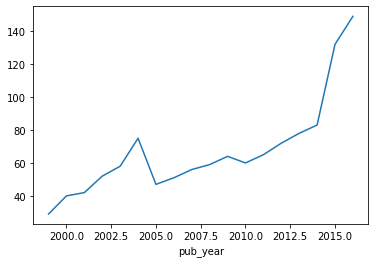

In [27]:
numAuthorsByYear.plot()

In [42]:
numberReviewsByYear = reviews.groupby(['pub_year']).agg({'reviewid':['count']}).stack()

<AxesSubplot:xlabel='pub_year,None'>

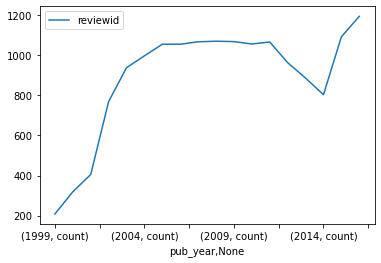

In [14]:
numberReviewsByYear.plot()

<AxesSubplot:>

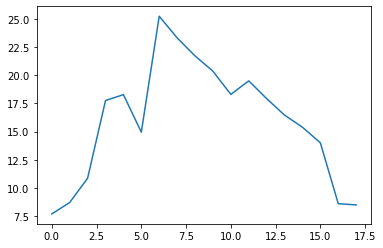

In [45]:
#Average number of reviews per author

import numpy as np
pd.Series(np.divide(numberReviewsByYear.values.flatten(),numAuthorsByYear.values.flatten())).plot()

In [36]:
#Who wrote the most number of reviews each year?

numberReviewsByYear = reviews[reviews.pub_year != 2017].groupby(['pub_year']).agg({'reviewid':['count']}).stack()

array([ 223,  348,  456,  923, 1060, 1121, 1186, 1189, 1216, 1201, 1171,
       1170, 1165, 1185, 1200, 1162, 1135, 1265,   17])

In [13]:
numberReviewsByYear = reviews.groupby(['pub_year']).agg({'reviewid':['count']}).stack()

In [ ]:

#Who wrote the fewest?

#Is there a correlation between number of words and number of reviews by author?

# Can Semantic Analysis Be used to infer the review score from the review content

In [6]:
#Sort by publish date so train, val, and test can be split in a way that maintains chronological order.
reviewIdSorted = reviews.sort_values(by = 'pub_date').reset_index()['reviewid']

#70/15/15 split for train/val/test
numberIds = len(reviewIdSorted)
valCutOff = numberIds//10*7
testCutOff = valCutOff + numberIds//20*3
trainIds = reviewIdSorted[0:valCutOff]
valIds = reviewIdSorted[valCutOff:testCutOff]
testIds = reviewIdSorted[testCutOff:]

In [7]:
#Join content and reviews dataframe on review id, keeping content (raw text of review) and score 
contentScorePairs = pd.merge(
    content[['reviewid', 'content']],
    reviews[['reviewid', 'score']],
    on = 'reviewid')

#Remove items with no written review
contentScorePairs = contentScorePairs[~contentScorePairs['content'].isna()]

trainContentScorePairs = contentScorePairs[contentScorePairs['reviewid'].isin(trainIds)]
valContentScorePairs = contentScorePairs[contentScorePairs['reviewid'].isin(valIds)]
testContentScorePairs = contentScorePairs[contentScorePairs['reviewid'].isin(testIds)]

In [10]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def tokenize(contentScorePair):
    text = list(contentScorePair['content'])
    tokenizedText = tokenizer(text, padding = True, truncation = True)
    return tokenizedText

xTrain = tokenize(trainContentScorePairs)
xVal = tokenize(valContentScorePairs)
xTest = tokenize(testContentScorePairs)

In [11]:
#Convert review score (with range 0.0 - 10.0) into classes.
#I choose to set the thresholds to be defined by the quantiles in the training set instead of even spacing.
#Fewer than 25% of scores are less than 6.3, so it would not be very useful to distguish between below 2.5 and between 2.5 and 5. 
#Distinguishing between 6.3 to 7.2 and 7.2 to 7.9 is much more interesting.
#I only use the training set because we don't know the true distribution of scores to be predicted.

vLowScoreLimit = trainContentScorePairs.score.quantile(.25) #6.3
lowScoreLimit = trainContentScorePairs.score.quantile(.5) #7.2
highScoreLimit = trainContentScorePairs.score.quantile(.75) #7.9
vHighScoreLimit = trainContentScorePairs.score.quantile(1) #10.0

def convertScore(score):
    if score <= vLowScoreLimit:
        y = 0
    elif score <= lowScoreLimit:
        y = 1
    elif score <= highScoreLimit:
        y = 2
    elif score <= vHighScoreLimit:
        y = 3
    else:
        y = 100000
    return y

trainContentScorePairs['target'] = trainContentScorePairs['score'].transform(lambda x: convertScore(x))
valContentScorePairs['target'] = valContentScorePairs['score'].transform(lambda x: convertScore(x))
testContentScorePairs['target'] = testContentScorePairs['score'].transform(lambda x: convertScore(x))

tTrain = list(trainContentScorePairs['target'].values)
tVal = list(valContentScorePairs['target'].values)
tTest = list(testContentScorePairs['target'].values)

<ipython-input-11-b9488c1b8a40>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainContentScorePairs['target'] = trainContentScorePairs['score'].transform(lambda x: convertScore(x))
<ipython-input-11-b9488c1b8a40>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valContentScorePairs['target'] = valContentScorePairs['score'].transform(lambda x: convertScore(x))
<ipython-input-11-b9488c1b8a40>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [12]:
#Combine x and t values to make Datasets, for easy input into Torch DataLoader

class reviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

trainDataset = reviewDataset(xTrain, tTrain)
valDataset = reviewDataset(xVal, tVal)
testDataset = reviewDataset(xTest, tTest)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=4)
model.to(device)
model.train()

trainLoader = DataLoader(trainDataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [14]:
print(device)

cpu


In [16]:
%xmode Verbose
from tqdm import tqdm
for batch in tqdm(trainLoader):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

  0%|          | 0/806 [00:00<?, ?it/s]

Exception reporting mode: Verbose


  4%|▍         | 34/806 [11:39<4:24:34, 20.56s/it]


KeyboardInterrupt: 